# Training Machine Learning Algorithms for Classification

Goals for this chapter:
* Build intuition for machine learning algorithms
* Use Pandas, NumPy, and matplotlib to read in, process, and visualize data
* Implement linear classification algorithms in Python

## Perceptron

The perceptron is used to classify a collection of data points into two seperate categories. it consists of a linear function on $\mathbb{R}^n$ followed by an activation function. A couple notes on it:
* Updates the wieghts after each data point passed through it.
* Will converge if the data is linearly seperable
* Not guarenteed to converge in any other cases. This means we must specify the number of passes over the training data.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Note the next cell just contains some simple functions I've written to help with common pandas functions

In [34]:
# %load https://raw.githubusercontent.com/ccastleberry/Panda_Tools/master/Panda_Tools.py
''' This is a library for some simple add ins for working quickly with a new datset '''


# Import Statements
import pandas as pd
import numpy as np

# The next few functions are for quickly creating 1 hot
# encoding of categorical columns in a pandas dataframe

def one_hot_column(df, label, drop_col=False):
    '''
    This function will one hot encode the chosen column.

    Args:
        df: Pandas dataframe
        label: Label of the column to encode
        drop_col: boolean to decide if the chosen column should be dropped

    Returns:
        pandas dataframe with the given encoding
    '''
    one_hot = pd.get_dummies(df[label])
    if drop_col:
        df = df.drop(label, axis=1)
    df = df.join(one_hot)
    return df


def one_hot(df, labels, drop_col=False):
    '''
    This function will one hot encode a list of columns.

    Args:
        df: Pandas dataframe
        labels: list of the columns to encode
        drop_col: boolean to decide if the chosen column should be dropped

    Returns:
        pandas dataframe with the given encoding
    '''
    for label in labels:
        df = one_hot_column(df, label, drop_col)
    return df

def shuffle(df, seed=13):
    '''
    This function will shuffle the rows and re-index a pandas dataframe

    Args:
        df: pandas dataframe
        seed: a seed for numpy random

    Returns:
        pandas dataframe
    '''

    np.random.seed(seed)
    df = df.iloc[np.random.permutation(len(df))]
    df = df.reset_index(drop=True)
    return df

### Definition

In [61]:
class Perceptron(object):
    '''Perceptron classifier
    
    Parameters:
        eta: float
            Learning Rate (0-1)
        n_iter: int
            passes over the training dataset
    Attributes:
        w_: 1d-array
            Weights after fitting
        errors_: list
            Number of misclassifications in every epoch.
    '''
    
    def __init__(self, eta=0.01, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
    
    
        
    
    def fit(self, X, y):
        '''Fit training data.
        
        Parameters:
            X: {array-like}, shape = [n_samples, n_features]
                Training vectors, where n_samplesis the number of rows
                and n_features is the number of columns.
            y: array-like, shape=[n_samples]
                Target values.
        Returns:
            self.object
        '''
        self.w_ = np.zeros(1+X.shape[1])
        self.errors_ = []
        
        for i in range(self.n_iter):            # Loop over number of epochs
            errors = 0
            for xi, target in zip(X,y):
                update = self.eta*(target - self.predict(xi))    # Error coefficient
                self.w_[1:]+= update*xi                          # Update vector weights
                self.w_[0]+=update                               # Update weight
                errors += int(update != 0.0)                     # Incorrect classifications this epoch
            self.errors_.append(errors)
        return self
    
    def net_input(self, X):
        '''Calculate net input.'''
        return np.dot(X, self.w_[1:] + self.w_[0])
    
    def predict(self, X):
        '''Return class label after unit step'''
        return np.where(self.net_input(X) >= 0.0, 1, -1)

### Training Perceptron on the Iris Dataset from SKLearn

Load in the dataset and get rid of the "virginica" species so that we only have to differentiate between two categories.

In [49]:
df = sns.load_dataset("iris")
df = df[df["species"]!="virginica"]
df = shuffle(df)
df.tail()

,sepal_length,sepal_width,petal_length,petal_width,species
95,5.0,3.0,1.6,0.2,setosa
96,5.4,3.9,1.3,0.4,setosa
97,6.4,2.9,4.3,1.3,versicolor
98,5.3,3.7,1.5,0.2,setosa
99,5.8,2.7,3.9,1.2,versicolor


In [50]:
df["species"].value_counts()

versicolor    50
setosa        50
Name: species, dtype: int64

Make a basic plot just to check out the structure of our data.

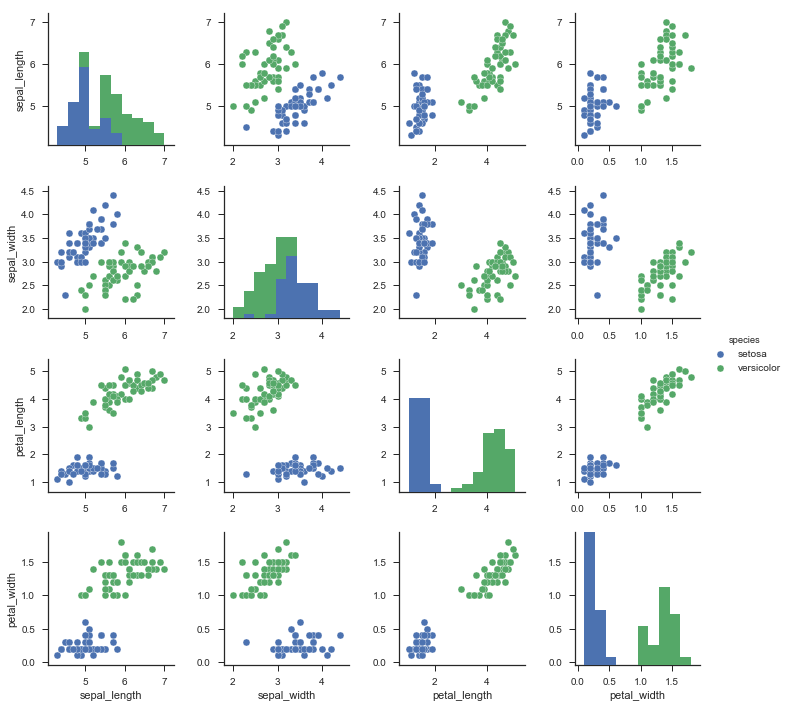

In [51]:
sns.set(style="ticks")
sns.pairplot(df, hue="species")
plt.show()

It looks as though our data is definitely linearly seperable. This means that our Perceptron should converge and give us accurate results. So here we will go ahead and do that then track the errors as it is trained.

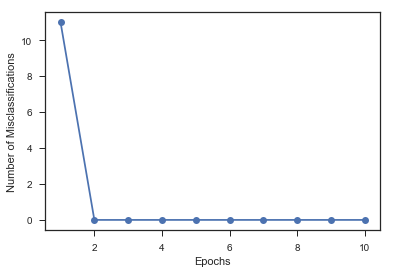

In [62]:
X = df.drop("species", axis=1).copy().values
y = df["species"].values
y = np.where(y == "setosa", -1, 1)

G_eta = 0.1
G_n_iter = 10
ppn = Perceptron(eta=G_eta, n_iter=G_n_iter)
ppn.fit(X, y)
plt.plot(range(1,len(ppn.errors_)+1), ppn.errors_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Number of Misclassifications")
plt.show()

In [64]:
ppn.errors_

[11, 0, 0, 0, 0, 0, 0, 0, 0, 0]

ok so that seemed to converge extremely quickly.

## Adaline

this is very similar to the structure of the perception except with one major difference: The weights are updated from an activation function rather than a unit step function.

### Implementation

In [77]:
class AdalineGD(object):
    '''ADAptive Linear Neuron classifier
    
    Parameters:
        eta: float
            Learning Rate (0-1)
        n_iter: int
            Passes over the training set
    
    ATtributes:
        w_: 1d_array
            weights after fitting
        errors_: list
            number of erros per epoch
    '''
    
    def __init__(self, eta=0.01, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter
        
    def fit(self, X, y):
        '''Fit training data.
        
        Parameters:
            X : {array-like}, shape = [n_samples, n_features]
                Training vectors, 
                where n_samples is the number of samples and
                n_features is the number of features.
            y : array-like, shape = [n_samples]
                Target values.

        Returns:
            self : object
        '''
        
        self.w_ = np.zeros(1+X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y-output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum()/2.0
            self.cost_.append(cost)
        
        return self
    
    def net_input(self, X):
        '''Calculate net input.'''
        return np.dot(X, self.w_[1:])+self.w_[0]
    
    def activation(self, X):
        '''Compute linear activation function'''
        return self.net_input(X)
    
    def predict(self, X):
        '''REturn class label after unit step'''
        return np.where(self.activation(X) >= 0.0, 1, -1)

Ok now let's use this to fit the data and then plot how accurate it is over the epochs.

Text(0.5,1,'Adaline - learning rate 0.0001')

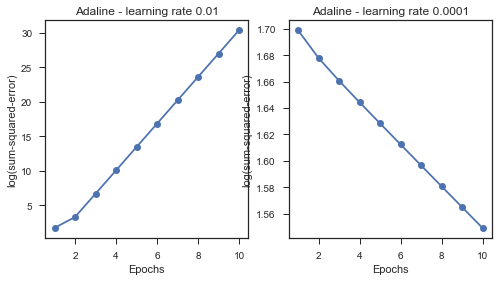

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X,y)
ax[0].plot(range(1, len(ada1.cost_) + 1),
          np.log10(ada1.cost_),
          marker="o")
ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X,y)
ax[1].plot(range(1, len(ada2.cost_) + 1),
          np.log10(ada2.cost_),
          marker="o")

ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log(sum-squared-error)")
ax[0].set_title("Adaline - learning rate 0.01")

ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("log(sum-squared-error)")
ax[1].set_title("Adaline - learning rate 0.0001")


Clearly 0.0001 works much better as a learning rate since 0.01 seems to cause worse and worse fitting.

## Large Scale Machine Learning and Stochastic Gradient Descent

We will now write a  version of Adaline where we don't train on the entire set every time but rather a small randomized subest every time.

In [89]:
from numpy.random import seed

class AdalineSGD(object):
    '''ADAptive Linear Neuron classifier
    
    Parameters:
        eta: float
            Learning Rate (0-1)
        n_iter: int
            Passes over the training set
    
    ATtributes:
        w_: 1d_array
            weights after fitting
        errors_: list
            number of erros per epoch
        shuffle: bool
            shuffles data every epoch is True
        random_state: int(default: None)
            set random state for shuffling 
            and initializing weights
    '''
    
    def __init__(self, eta=0.01, n_iter=10,
                shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
            
            
    def fit(self, X, y):
        '''Fit training data.
        
        Parameters:
            X : {array-like}, shape = [n_samples, n_features]
                Training vectors, 
                where n_samples is the number of samples and
                n_features is the number of features.
            y : array-like, shape = [n_samples]
                Target values.

        Returns:
            self : object
        '''
        
        self.w_ = np.zeros(1+X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost)/len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        '''Fit training data without resetting weights'''
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        '''Shuffle data.'''
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self,m):
        '''initialize weights to zero'''
        self.w_ = np.zeros(1+m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        '''Apply Adaline learning rule ot update weights.'''
        output = self.net_input(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        '''Calculate net input.'''
        return np.dot(X, self.w_[1:])+self.w_[0]
    
    def activation(self, X):
        '''Compute linear activation function'''
        return self.net_input(X)
    
    def predict(self, X):
        '''REturn class label after unit step'''
        return np.where(self.activation(X) >= 0.0, 1, -1)

In [87]:
X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

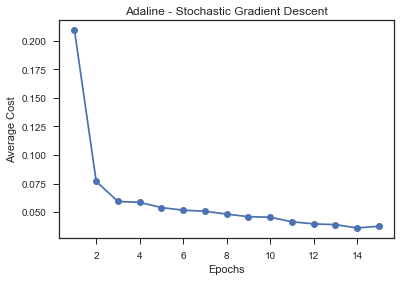

In [91]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)
plt.title('Adaline - Stochastic Gradient Descent')
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.show()